<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/2020_11_24_GridSearchCV_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# !!VIRTUALLY DONE!! 
Ideally - no more changes here, there's a lot of meat to this one and I need to use it to generate results for report, can't afford to break it :) 

# WORDS OF CAUTION

I initially ran GridSearchCV on the whole X,y dataset (i.e. ignoring X_train/ y_train, X_test/ y_test) and spat out the best results without evaluation on unseen data. See...
* See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

i.e. With GridSearchCV, I need to..
* setup model
* fit with X_train/ y_train
* evaluate and find best model
* take best model and use X_test/ y_test on it





Also from...
* https://stackoverflow.com/a/55605798

"Internally, GridSearchCV splits the dataset given to it into various training and validation subsets, and, using the hyperparameter grid provided to it, finds the single set of hyperparameters that give the best score on the validation subsets.

The point of a train-test split is then, after this process is done, to perform one final scoring on the test data, which has so far been unknown to the model, to see if your hyperparameters have been overfit to the validation subsets. If it does well, then the next step is putting the model into production/deployment."

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
#!pip uninstall scikit-learn -y
#!pip install scikit-learn
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [2]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [3]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 57
-rw------- 1 root root 33561 Dec 13 15:21 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [5]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [64]:
# regular imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# object that provides colours for charts
from itertools import cycle

# sklearn imports
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [52]:
# install required libs
#!pip install mido

In [7]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2020-12-14 21:27:17.696357, module name: stats_n_features
>> LOADING custom module, when: 2020-12-14 21:27:17.697692, module name: data_prep
>> LOADING custom module, when: 2020-12-14 21:27:17.701042, module name: pipeline_utils


In [8]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

Test function in data_prep.py called and worked! when: 2020-12-14 21:27:20.732317,  param:bling
Test function in stats_n_features called and worked! when: 2020-12-14 21:27:20.732491,  param:hello


## Pandas display options

In [9]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [10]:
##################################
######## LOAD

my_data = dp.load_all_data()
all_drummer_data = my_data.copy()
;

BULK LOAD: drummer1, drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid, funk/groove1
FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    __notes pre-filter: [36. 37. 38. 40. 43. 44. 51. 52. 53. 55.]
    __applying filter: [44]
    __notes post filter: [36. 37. 38. 40. 43. 51. 52. 53. 55.]
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 5, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 43.

''

In [11]:
logs_df = dp.get_last_logs()
display(logs_df.head(3))
filtered_logs_df = logs_df[['style', 'tempo_us', 'tempo_bpm', 'ts_num', 'ts_den', 'PPQN', 'bars_in_file', 'ticks_per_bin', 'ms_per_bin']]
#check_stats_df = filtered_logs_df.groupby('style').agg([pd.Series.mode, 'nunique'])
check_stats_df = filtered_logs_df.groupby('style').agg([pd.Series.mode])
check_stats_df.columns = check_stats_df.columns.droplevel(1)
#check_stats_df.to_csv(r'/content/drive/My Drive/check_stats_df.csv')
display(check_stats_df)

,file_name,style,drummer,file_type,ts_num,ts_den,tempo_us,tempo_bpm,PPQN,first_hit,last_hit,bars_in_file,quantize_level,ticks_per_beat,ticks_per_bin,ms_per_bin,err_buckets
0,drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid,funk/groove1,drummer1,0,4,4,434783,137.999876,480,3,30658,16,16.0,480.0,120,0.108696,"(24, 13)"
1,drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid,soul/groove3,drummer1,0,4,4,697674,86.000052,480,0,30696,16,16.0,480.0,120,0.174419,"(8, 13)"
2,drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid,soul/groove4,drummer1,0,4,4,750000,80.000000,480,0,30470,16,16.0,480.0,120,0.187500,"(0, 13)"


,tempo_us,tempo_bpm,ts_num,ts_den,PPQN,bars_in_file,ticks_per_bin,ms_per_bin
style,,,,,,,,
funk/groove1,434783,137.999876,4,4,480,16,120,0.108696
hiphop/groove6,689655,87.000022,4,4,480,16,120,0.172414
rock/groove8,923077,64.999995,4,4,480,16,120,0.230769
soul/groove3,697674,86.000052,4,4,480,16,120,0.174419
soul/groove4,750000,80.000000,4,4,480,16,120,0.187500


In [12]:
# new method of loading data..
master_df = all_drummer_data['master_df']

## Filter songs...

Take a look at all file names in the complete data set...

In [13]:
list(all_drummer_data.keys())

['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.m

In [14]:
# compare to new method of loading data..
master_df.head(3)

,drummer_ID,note,velocity,beat_offset,beat_offset_ms,bar_beat_number,style
0,drummer1,hh,55,7,0.006341,1,funk/groove1
1,drummer1,kick,64,10,0.009058,1,funk/groove1
2,drummer1,kick,57,-29,-0.026268,3,funk/groove1


# Setup & select data to use

**NOTE: v1 data format reqd for modelling**

Specifically, these models initially setup to use DFs with the following features...
1. drummer_ID
2. note
3. velocity
4. beat_offset	
5. bar_beat_number

In v2 of the dataframes from the loading code includes additional cols for ..
6. beat_offset_ms
7. style

When doing further work on models using v2 versions of data, need to ensure to drop cols for  'beat_offset_ms' and 'style' to duplicate previous results.

**v2 example...**

In [15]:
master_df.head()
print('\n > list of styles in dataset: {}'.format(master_df['style'].unique()))

,drummer_ID,note,velocity,beat_offset,beat_offset_ms,bar_beat_number,style
0,drummer1,hh,55,7,0.006341,1,funk/groove1
1,drummer1,kick,64,10,0.009058,1,funk/groove1
2,drummer1,kick,57,-29,-0.026268,3,funk/groove1
3,drummer1,hh,31,-2,-0.001812,3,funk/groove1
4,drummer1,hh,54,-13,-0.011775,5,funk/groove1



 > list of styles in dataset: ['funk/groove1' 'soul/groove3' 'soul/groove4' 'hiphop/groove6'
 'rock/groove8']


**v1 example, drop cols steps reqd...**

In [16]:
# drop cols to exclude from modelling
master_df.drop(columns=['beat_offset_ms', 'style']).head()

,drummer_ID,note,velocity,beat_offset,bar_beat_number
0,drummer1,hh,55,7,1
1,drummer1,kick,64,10,1
2,drummer1,kick,57,-29,3
3,drummer1,hh,31,-2,3
4,drummer1,hh,54,-13,5


## Song style selection

In [17]:
# make a copy
working_data = master_df.copy() 

# select/ filter to subset of styles if required.
# skip this step, comment out next line of code to use all data
# select from ['funk/groove1' 'soul/groove3' 'soul/groove4' 'hiphop/groove6' 'rock/groove8']
working_data = working_data[working_data['style'] == 'hiphop/groove6']

# drop cols to exclude from modelling
#working_data.drop(columns=['beat_offset_ms', 'style'], inplace=True)
working_data.drop(columns=['beat_offset_ms'], inplace=True)

In [18]:
working_data.head(3)
working_data.describe(include='all')

,drummer_ID,note,velocity,beat_offset,bar_beat_number,style
922,drummer1,kick,127,0,1,hiphop/groove6
923,drummer1,hh,58,9,1,hiphop/groove6
924,drummer1,hh,17,-5,2,hiphop/groove6


,drummer_ID,note,velocity,beat_offset,bar_beat_number,style
count,1221,1221,1221.000000,1221.000000,1221.000000,1221
unique,4,3,NaN,NaN,NaN,1
top,drummer1,hh,NaN,NaN,NaN,hiphop/groove6
freq,360,698,NaN,NaN,NaN,1221
mean,NaN,NaN,68.886978,-6.131859,8.641278,NaN
std,NaN,NaN,34.689707,14.838689,4.426530,NaN
min,NaN,NaN,5.000000,-57.000000,1.000000,NaN
25%,NaN,NaN,40.000000,-16.000000,5.000000,NaN
50%,NaN,NaN,64.000000,-6.000000,9.000000,NaN
75%,NaN,NaN,95.000000,4.000000,13.000000,NaN


## X, y split

Break into X, y before continuing ...

In [19]:
# BREAK INTO X, y
y = working_data['drummer_ID'].to_numpy()
X = working_data.drop(['drummer_ID' ], axis=1) #.to_numpy()

In [20]:
X.head(10)

,note,velocity,beat_offset,bar_beat_number,style
922,kick,127,0,1,hiphop/groove6
923,hh,58,9,1,hiphop/groove6
924,hh,17,-5,2,hiphop/groove6
925,hh,75,-1,3,hiphop/groove6
926,hh,16,-9,4,hiphop/groove6
927,kick,58,0,4,hiphop/groove6
928,hh,60,2,5,hiphop/groove6
929,snare,107,2,5,hiphop/groove6
930,hh,21,0,6,hiphop/groove6
931,hh,84,9,7,hiphop/groove6


## Train/ test split...

TODO: compare use of stratify parameter, with not using it?

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [21]:
# TEST/ TRAIN SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27, stratify=y)


In [22]:
X_train.head(3)

,note,velocity,beat_offset,bar_beat_number,style
2485,kick,14,-13,16,hiphop/groove6
3887,hh,127,-15,13,hiphop/groove6
936,hh,33,7,10,hiphop/groove6


In [23]:
X_train.describe(include='all')
X_test.describe(include='all')

,note,velocity,beat_offset,bar_beat_number,style
count,976,976.000000,976.000000,976.000000,976
unique,3,NaN,NaN,NaN,1
top,hh,NaN,NaN,NaN,hiphop/groove6
freq,568,NaN,NaN,NaN,976
mean,NaN,69.394467,-6.241803,8.594262,NaN
std,NaN,34.876443,14.696552,4.432899,NaN
min,NaN,5.000000,-55.000000,1.000000,NaN
25%,NaN,40.000000,-16.000000,5.000000,NaN
50%,NaN,64.000000,-6.000000,9.000000,NaN
75%,NaN,96.000000,4.000000,12.250000,NaN


,note,velocity,beat_offset,bar_beat_number,style
count,245,245.000000,245.000000,245.000000,245
unique,3,NaN,NaN,NaN,1
top,hh,NaN,NaN,NaN,hiphop/groove6
freq,130,NaN,NaN,NaN,245
mean,NaN,66.865306,-5.693878,8.828571,NaN
std,NaN,33.930290,15.415029,4.405101,NaN
min,NaN,5.000000,-57.000000,1.000000,NaN
25%,NaN,40.000000,-15.000000,6.000000,NaN
50%,NaN,64.000000,-5.000000,9.000000,NaN
75%,NaN,90.000000,5.000000,13.000000,NaN


# Setup pipelines

In [74]:
working_data.corr()

,velocity,beat_offset,bar_beat_number
velocity,1.000000,0.132697,-0.163606
beat_offset,0.132697,1.000000,-0.026914
bar_beat_number,-0.163606,-0.026914,1.000000


## Create transformers

In [75]:
beat_pos_cats = list(np.arange(1, 17))
beat_pos_cats

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [87]:
t_one_hot_beat_pos = OneHotEncoder(drop='first', categories=[beat_pos_cats])    # beat_pos

t_scaler_std = StandardScaler(with_mean=True, with_std=True) # defaults made explict, velocity, beat_offset

t_one_hot = OneHotEncoder(drop='first')    # instrument, style
t_scaler_robust = RobustScaler(quantile_range=(25, 75))  # try with: velocity, beat_offset
t_scaler_mm_1 = MinMaxScaler(feature_range=(0, 1))       # velocity
t_scaler_mm_2 = MinMaxScaler(feature_range=(-0.5, 0.5))  # beat_offset

# robust scaling for numerical, dummies for categorical
t_v0_robust = [('t_scaler_robust', t_scaler_robust, ['velocity', 'beat_offset']), 
               ('t_one_hot', t_one_hot, ['note', 'style']),
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v0 = ColumnTransformer(transformers=t_v0_robust, remainder='passthrough', sparse_threshold=0)
 
# MinMax scaling for numerical, dummies for categorical
t_v1_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity']),
               ('t_scaler_mm_2', t_scaler_mm_2, ['beat_offset']),
               ('t_one_hot', t_one_hot, ['note', 'style']),
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])] 
ct_v1 = ColumnTransformer(transformers=t_v1_mm, remainder='passthrough', sparse_threshold=0)

# MinMax scaling for numerical, dummies for categorical
t_v2_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity']),
               ('t_scaler_mm_2', t_scaler_mm_2, ['beat_offset']), 
               ('t_one_hot', t_one_hot, ['note', 'style'])]
ct_v2 = ColumnTransformer(transformers=t_v2_mm, remainder='passthrough', sparse_threshold=0)

# MinMax scaling for numerical, dummies for categorical
t_v3_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity', 'beat_offset']), ('t_one_hot', t_one_hot, ['note', 'style'])]
ct_v3 = ColumnTransformer(transformers=t_v3_mm, remainder='passthrough', sparse_threshold=0)

# Std scaling for numerical, dummies for categorical
# NB: this is the least 'custom'
t_v4_std = [('t_scaler_std', t_scaler_std, ['velocity', 'beat_offset']),
           ('t_one_hot', t_one_hot, ['note', 'style']),
           ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v4 = ColumnTransformer(transformers=t_v4_std, remainder='passthrough', sparse_threshold=0)

# MinMax scaling for numerical, dummies for categorical
t_v5_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity', 'beat_offset']), 
           ('t_one_hot', t_one_hot, ['note', 'style']),
           ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v5 = ColumnTransformer(transformers=t_v5_mm, remainder='passthrough', sparse_threshold=0)

# dummy encode categories, leave everything else untouched, e.g. for DT
t_ord_enc = [('t_label_enc', OrdinalEncoder(), ['note','style'])]
ct_ord_enc  = ColumnTransformer(transformers=t_ord_enc, remainder='passthrough', sparse_threshold=0)


In [88]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context


In [89]:
ct_v0
ct_v1
ct_v2
ct_v3
ct_v4
ct_v5
ct_ord_enc 

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_robust',
                                 RobustScaler(quantile_range=(25, 75)),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), ['velocity']),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)),
                                 ['beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), ['velocity']),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)),
                                 ['beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_std', StandardScaler(),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_label_enc', OrdinalEncoder(),
                                 ['note', 'style'])])

## Sanity checking ..


Try a transformer, peek at the outputs...

In [90]:
output1 = ct_v1.fit_transform(X)
output2 = ct_v2.fit_transform(X)
output3 = ct_v3.fit_transform(X)
output4 = ct_v4.fit_transform(X)
output5 = ct_v5.fit_transform(X)

In [31]:
output1.shape
pd.DataFrame(output1).head()

(1221, 19)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,-0.008621,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.434426,0.068966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.098361,-0.051724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.573770,-0.017241,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.090164,-0.086207,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
output2.shape
tmp_df = pd.DataFrame(output2)
tmp_df.head()
#tmp_df.corr()


(5631, 9)

,0,1,2,3,4,5,6,7,8
0,0.414634,0.063025,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.487805,0.088235,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.430894,-0.239496,1.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.219512,-0.012605,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,0.406504,-0.105042,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [ ]:
output3.shape
tmp_df = pd.DataFrame(output3)
tmp_df.head()
#tmp_df.corr()

(5631, 9)

,0,1,2,3,4,5,6,7,8
0,0.414634,0.563025,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.487805,0.588235,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.430894,0.260504,1.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.219512,0.487395,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,0.406504,0.394958,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [ ]:
output4.shape
tmp_df = pd.DataFrame(output4)
tmp_df.head()
#tmp_df.corr()

(5631, 23)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,-0.385394,0.842394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.119697,1.050325,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.326350,-1.652773,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.093919,0.218602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.414916,-0.543810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Some pipelines

In [32]:
# setup our pre-processing and modelling pipeline
pipe_v0 = Pipeline(steps=[('prep',ct_v0), ('knn', KNeighborsClassifier(7))])
pipe_v1 = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
pipe_v2 = Pipeline(steps=[('prep',ct_v2), ('knn', KNeighborsClassifier(7))])
pipe_v3 = Pipeline(steps=[('prep',ct_v3), ('knn', KNeighborsClassifier(7))])
pipe_v4 = Pipeline(steps=[('prep',ct_v4), ('knn', KNeighborsClassifier(7))])
pipe_v5 = Pipeline(steps=[('prep',ct_v5), ('knn', KNeighborsClassifier(7))])


# Util functions


In [79]:

def KNN_predict(X_train, y_train, X_test, n=5):
  # Fit model, do predictions

  KNN_model = KNeighborsClassifier(n)
  display(KNN_model)
  KNN_model.fit(X_train, y_train)
  return KNN_model.predict(X_test)

def display_classify_results(y_true, y_pred, labels):

  print('\nAccuracy score {}'.format(accuracy_score(y_true=y_true, y_pred=y_pred)))

  print('\nClassification report...')
  print(classification_report(y_true=y_true, y_pred=y_pred, labels=labels))

  print('\nConfusion matrix...')
  matrix2 = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
  m_df = pd.DataFrame(matrix2, index=labels, columns=labels)
  _ = plt.figure(figsize=(6, 6))
  sns.heatmap(m_df, annot=True, cbar=None, cmap="Reds")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()



# Manual KNN to test pipelines

## Manual fit model, do predictions

Testing single model by hand

In [80]:
print('fitting the pipeline ...')
#pipe_v3.fit(X_train, y_train)
#pipe_v0.fit(X_train, y_train)
pipe_v5.fit(X_train, y_train)

print('predicting ...')
#predictions_1 = pipe_v3.predict(X_test)
#predictions_1 = pipe_v0.predict(X_test)
predictions_1 = pipe_v5.predict(X_test)

fitting the pipeline ...


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity', 'beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

predicting ...


## Evaluate model results


Accuracy score 0.7551020408163265

Classification report...
              precision    recall  f1-score   support

    drummer1       0.68      0.65      0.67        72
    drummer5       0.80      0.83      0.81        47
    drummer7       0.81      0.80      0.80        64
    drummer8       0.75      0.77      0.76        62

    accuracy                           0.76       245
   macro avg       0.76      0.76      0.76       245
weighted avg       0.75      0.76      0.75       245


Confusion matrix...


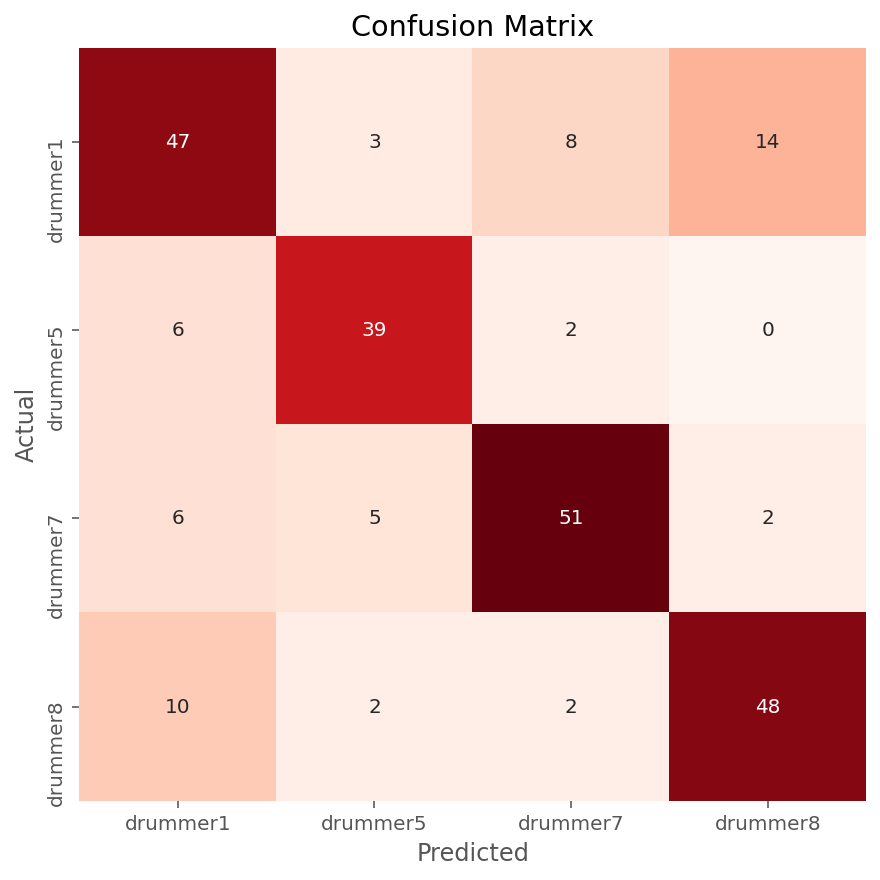

In [81]:
# y = list of all y values from dataset
classes = np.unique(y)
display_classify_results(y_test, predictions_1, classes)

# DummyClassifier
See...
* https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier

In [82]:

# uniform, stratified, most_frequent, prior, constant
dummy_clf = DummyClassifier(strategy='stratified', random_state=0)
dummy_clf.fit(X_train, y_train)
print('clf score: {}'.format(dummy_clf.score(X_test, y_test)))
y_pred = dummy_clf.predict(X_test)


DummyClassifier(random_state=0, strategy='stratified')

clf score: 0.2693877551020408



Accuracy score 0.2693877551020408

Classification report...
              precision    recall  f1-score   support

    drummer1       0.29      0.29      0.29        72
    drummer5       0.20      0.19      0.19        47
    drummer7       0.34      0.38      0.36        64
    drummer8       0.21      0.19      0.20        62

    accuracy                           0.27       245
   macro avg       0.26      0.26      0.26       245
weighted avg       0.27      0.27      0.27       245


Confusion matrix...


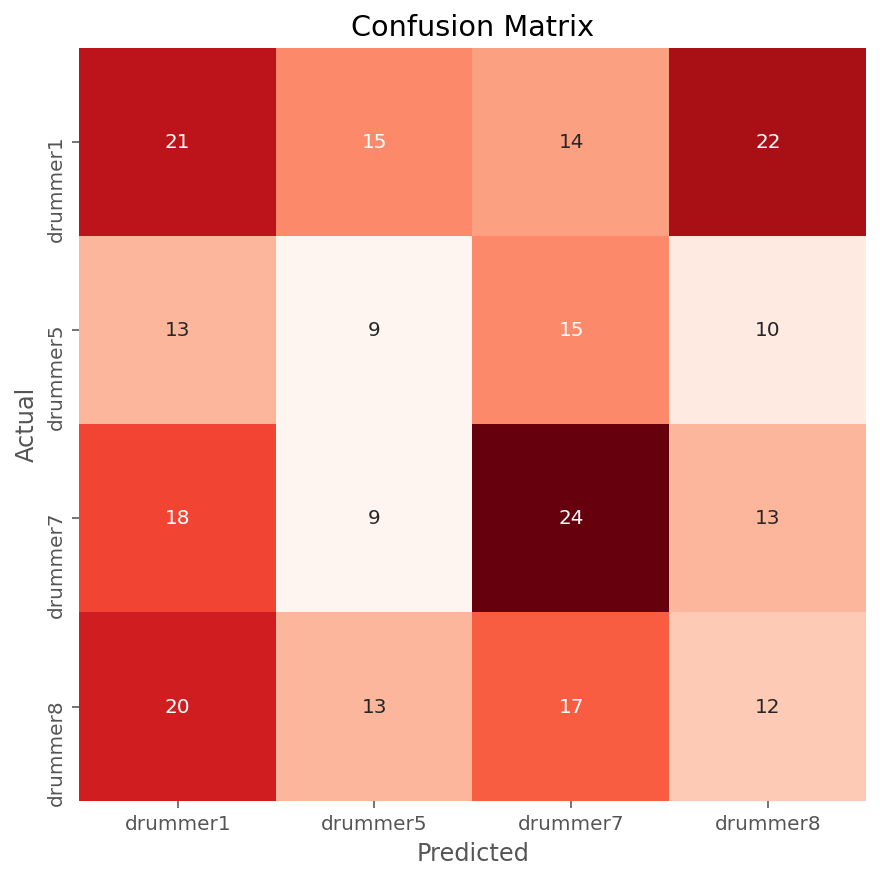

In [83]:
# y = list of all y values from dataset
classes = np.unique(y)
display_classify_results(y_test, y_pred, classes)

# K-fold CV, manual loop thru pipes

Compares..
* k=1-20
* 4 different pre-processing pipes

::TODO:: try different cv values.

In [43]:
pca = PCA()

# list of ColumnTransformers setup earlier ..
cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4, ct_v5]

results = []
best_score = 0
best_info = ''
best_pipe = None
best_k = 0

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=27)

for idx, ct in enumerate(cts):
  print("\n_______________________________________________________")
  print("\n>>>> pipe #{}.. \n".format(idx))
  
  # Calculating error for K values between 1 and 20
  for next_k in range(1, 20):
    next_pipe = Pipeline(steps=[('prep',ct), ('pca', pca), ('knn', KNeighborsClassifier(next_k))])
    cv_results = cross_val_score(next_pipe, X_train, y_train, cv=kf, scoring="accuracy", n_jobs=-1 )
    results.append(cv_results)

    # print out put of this run.
    this_mean = cv_results.mean()
    this_run = "pipe #{}, k={}, mean:{}".format(idx, next_k, this_mean)
    print('\n\n ___ '+this_run)
    cv_results

    # check for best
    if this_mean > best_score:
      best_score = this_mean
      best_info = this_run
      best_pipe = next_pipe
      best_k = next_k
    
print("\n\nBest score was > {}".format(best_score))
print(best_info)




_______________________________________________________

>>>> pipe #0.. 



 ___ pipe #0, k=1, mean:0.7274879023774459


array([0.65306122, 0.76530612, 0.79591837, 0.67346939, 0.70408163,
       0.74489796, 0.7628866 , 0.69072165, 0.81443299, 0.67010309])



 ___ pipe #0, k=2, mean:0.7018619819061646


array([0.65306122, 0.7244898 , 0.75510204, 0.66326531, 0.69387755,
       0.70408163, 0.70103093, 0.65979381, 0.7628866 , 0.70103093])



 ___ pipe #0, k=3, mean:0.7213759730696403


array([0.67346939, 0.73469388, 0.74489796, 0.69387755, 0.67346939,
       0.74489796, 0.7628866 , 0.69072165, 0.77319588, 0.72164948])



 ___ pipe #0, k=4, mean:0.7121502209131074


array([0.67346939, 0.70408163, 0.70408163, 0.7244898 , 0.68367347,
       0.7244898 , 0.75257732, 0.63917526, 0.77319588, 0.74226804])



 ___ pipe #0, k=5, mean:0.7060382916053018


array([0.63265306, 0.7244898 , 0.69387755, 0.67346939, 0.67346939,
       0.74489796, 0.72164948, 0.65979381, 0.77319588, 0.7628866 ])



 ___ pipe #0, k=6, mean:0.6854828529349885


array([0.65306122, 0.70408163, 0.64285714, 0.70408163, 0.64285714,
       0.73469388, 0.72164948, 0.59793814, 0.73195876, 0.72164948])



 ___ pipe #0, k=7, mean:0.6926888281085631


array([0.62244898, 0.68367347, 0.67346939, 0.71428571, 0.65306122,
       0.74489796, 0.73195876, 0.62886598, 0.72164948, 0.75257732])



 ___ pipe #0, k=8, mean:0.69062697243846


array([0.64285714, 0.65306122, 0.70408163, 0.69387755, 0.65306122,
       0.74489796, 0.72164948, 0.63917526, 0.73195876, 0.72164948])



 ___ pipe #0, k=9, mean:0.6803702924468757


array([0.63265306, 0.63265306, 0.66326531, 0.70408163, 0.66326531,
       0.74489796, 0.67010309, 0.62886598, 0.72164948, 0.74226804])



 ___ pipe #0, k=10, mean:0.6639911634756995


array([0.58163265, 0.62244898, 0.66326531, 0.68367347, 0.62244898,
       0.75510204, 0.67010309, 0.58762887, 0.72164948, 0.73195876])



 ___ pipe #0, k=11, mean:0.6619293078055966


array([0.62244898, 0.63265306, 0.63265306, 0.69387755, 0.6122449 ,
       0.73469388, 0.68041237, 0.60824742, 0.67010309, 0.73195876])



 ___ pipe #0, k=12, mean:0.6435093625078897


array([0.60204082, 0.64285714, 0.63265306, 0.64285714, 0.60204082,
       0.67346939, 0.6185567 , 0.59793814, 0.72164948, 0.70103093])



 ___ pipe #0, k=13, mean:0.6333052808752366


array([0.54081633, 0.62244898, 0.58163265, 0.66326531, 0.60204082,
       0.68367347, 0.63917526, 0.59793814, 0.73195876, 0.67010309])



 ___ pipe #0, k=14, mean:0.6291815695350305


array([0.56122449, 0.64285714, 0.55102041, 0.66326531, 0.59183673,
       0.68367347, 0.60824742, 0.6185567 , 0.71134021, 0.65979381])



 ___ pipe #0, k=15, mean:0.6291920892068168


array([0.58163265, 0.60204082, 0.55102041, 0.65306122, 0.62244898,
       0.67346939, 0.67010309, 0.59793814, 0.69072165, 0.64948454])



 ___ pipe #0, k=16, mean:0.625078897538397


array([0.57142857, 0.58163265, 0.57142857, 0.65306122, 0.63265306,
       0.66326531, 0.63917526, 0.58762887, 0.70103093, 0.64948454])



 ___ pipe #0, k=17, mean:0.6281190826846202


array([0.57142857, 0.58163265, 0.60204082, 0.66326531, 0.63265306,
       0.67346939, 0.62886598, 0.60824742, 0.70103093, 0.6185567 ])



 ___ pipe #0, k=18, mean:0.6126762045024196


array([0.56122449, 0.57142857, 0.57142857, 0.69387755, 0.63265306,
       0.67346939, 0.62886598, 0.55670103, 0.65979381, 0.57731959])



 ___ pipe #0, k=19, mean:0.606480117820324


array([0.58163265, 0.59183673, 0.56122449, 0.70408163, 0.65306122,
       0.62244898, 0.63917526, 0.56701031, 0.59793814, 0.54639175])


_______________________________________________________

>>>> pipe #1.. 



 ___ pipe #1, k=1, mean:0.7417841363349463


array([0.69387755, 0.7755102 , 0.80612245, 0.70408163, 0.7244898 ,
       0.76530612, 0.79381443, 0.70103093, 0.80412371, 0.64948454])



 ___ pipe #1, k=2, mean:0.7172207027140753


array([0.68367347, 0.70408163, 0.75510204, 0.68367347, 0.7244898 ,
       0.74489796, 0.73195876, 0.67010309, 0.80412371, 0.67010309])



 ___ pipe #1, k=3, mean:0.7603408373658742


array([0.75510204, 0.73469388, 0.76530612, 0.75510204, 0.7244898 ,
       0.73469388, 0.79381443, 0.74226804, 0.86597938, 0.73195876])



 ___ pipe #1, k=4, mean:0.7439406690511257


array([0.70408163, 0.70408163, 0.74489796, 0.74489796, 0.7244898 ,
       0.75510204, 0.74226804, 0.73195876, 0.8556701 , 0.73195876])



 ___ pipe #1, k=5, mean:0.7440037870818431


array([0.70408163, 0.69387755, 0.71428571, 0.76530612, 0.69387755,
       0.74489796, 0.79381443, 0.71134021, 0.84536082, 0.77319588])



 ___ pipe #1, k=6, mean:0.7295813170629076


array([0.73469388, 0.71428571, 0.73469388, 0.75510204, 0.64285714,
       0.7244898 , 0.78350515, 0.70103093, 0.81443299, 0.69072165])



 ___ pipe #1, k=7, mean:0.7254365663791289


array([0.75510204, 0.66326531, 0.7244898 , 0.76530612, 0.67346939,
       0.74489796, 0.75257732, 0.67010309, 0.77319588, 0.73195876])



 ___ pipe #1, k=8, mean:0.717294340416579


array([0.7244898 , 0.68367347, 0.70408163, 0.71428571, 0.67346939,
       0.7244898 , 0.77319588, 0.68041237, 0.77319588, 0.72164948])



 ___ pipe #1, k=9, mean:0.6978224279402483


array([0.7244898 , 0.64285714, 0.66326531, 0.68367347, 0.68367347,
       0.71428571, 0.72164948, 0.67010309, 0.74226804, 0.73195876])



 ___ pipe #1, k=10, mean:0.6824742268041237


array([0.68367347, 0.63265306, 0.66326531, 0.66326531, 0.66326531,
       0.69387755, 0.73195876, 0.67010309, 0.70103093, 0.72164948])



 ___ pipe #1, k=11, mean:0.6598148537765622


array([0.66326531, 0.6122449 , 0.64285714, 0.69387755, 0.66326531,
       0.70408163, 0.69072165, 0.59793814, 0.67010309, 0.65979381])



 ___ pipe #1, k=12, mean:0.6464548706080372


array([0.60204082, 0.6122449 , 0.64285714, 0.68367347, 0.70408163,
       0.69387755, 0.64948454, 0.55670103, 0.65979381, 0.65979381])



 ___ pipe #1, k=13, mean:0.6188302124973701


array([0.59183673, 0.60204082, 0.59183673, 0.68367347, 0.65306122,
       0.6122449 , 0.64948454, 0.53608247, 0.62886598, 0.63917526])



 ___ pipe #1, k=14, mean:0.6013359983168526


array([0.58163265, 0.60204082, 0.58163265, 0.63265306, 0.66326531,
       0.64285714, 0.58762887, 0.5257732 , 0.57731959, 0.6185567 ])



 ___ pipe #1, k=15, mean:0.5767304860088365


array([0.58163265, 0.56122449, 0.56122449, 0.62244898, 0.63265306,
       0.6122449 , 0.54639175, 0.4742268 , 0.56701031, 0.60824742])



 ___ pipe #1, k=16, mean:0.5715653271617925


array([0.56122449, 0.55102041, 0.6122449 , 0.59183673, 0.63265306,
       0.63265306, 0.53608247, 0.46391753, 0.55670103, 0.57731959])



 ___ pipe #1, k=17, mean:0.5613822848727119


array([0.58163265, 0.52040816, 0.57142857, 0.59183673, 0.59183673,
       0.60204082, 0.57731959, 0.50515464, 0.51546392, 0.55670103])



 ___ pipe #1, k=18, mean:0.5399221544287818


array([0.55102041, 0.46938776, 0.52040816, 0.6122449 , 0.54081633,
       0.58163265, 0.58762887, 0.49484536, 0.50515464, 0.53608247])



 ___ pipe #1, k=19, mean:0.5133284241531664


array([0.58163265, 0.43877551, 0.52040816, 0.51020408, 0.5       ,
       0.52040816, 0.57731959, 0.49484536, 0.46391753, 0.5257732 ])


_______________________________________________________

>>>> pipe #2.. 



 ___ pipe #2, k=1, mean:0.7428150641699979


array([0.69387755, 0.7755102 , 0.80612245, 0.70408163, 0.71428571,
       0.7755102 , 0.79381443, 0.70103093, 0.81443299, 0.64948454])



 ___ pipe #2, k=2, mean:0.7213023353671366


array([0.68367347, 0.71428571, 0.76530612, 0.68367347, 0.7244898 ,
       0.76530612, 0.73195876, 0.67010309, 0.80412371, 0.67010309])



 ___ pipe #2, k=3, mean:0.7644014306753629


array([0.75510204, 0.74489796, 0.7755102 , 0.75510204, 0.73469388,
       0.76530612, 0.78350515, 0.74226804, 0.8556701 , 0.73195876])



 ___ pipe #2, k=4, mean:0.7470124132127077


array([0.69387755, 0.71428571, 0.74489796, 0.75510204, 0.7244898 ,
       0.76530612, 0.74226804, 0.73195876, 0.8556701 , 0.74226804])



 ___ pipe #2, k=5, mean:0.7470544918998527


array([0.70408163, 0.70408163, 0.7244898 , 0.76530612, 0.69387755,
       0.76530612, 0.79381443, 0.71134021, 0.83505155, 0.77319588])



 ___ pipe #2, k=6, mean:0.7305912055543867


array([0.73469388, 0.71428571, 0.74489796, 0.75510204, 0.64285714,
       0.73469388, 0.78350515, 0.70103093, 0.80412371, 0.69072165])



 ___ pipe #2, k=7, mean:0.7233747107090258


array([0.75510204, 0.66326531, 0.7244898 , 0.76530612, 0.67346939,
       0.74489796, 0.75257732, 0.65979381, 0.7628866 , 0.73195876])



 ___ pipe #2, k=8, mean:0.7162634125815275


array([0.7244898 , 0.68367347, 0.70408163, 0.71428571, 0.67346939,
       0.7244898 , 0.77319588, 0.68041237, 0.7628866 , 0.72164948])



 ___ pipe #2, k=9, mean:0.6978224279402483


array([0.7244898 , 0.64285714, 0.66326531, 0.68367347, 0.68367347,
       0.71428571, 0.73195876, 0.67010309, 0.73195876, 0.73195876])



 ___ pipe #2, k=10, mean:0.6824637071323375


array([0.68367347, 0.64285714, 0.66326531, 0.68367347, 0.64285714,
       0.69387755, 0.73195876, 0.67010309, 0.69072165, 0.72164948])



 ___ pipe #2, k=11, mean:0.6598148537765622


array([0.66326531, 0.6122449 , 0.64285714, 0.70408163, 0.65306122,
       0.70408163, 0.69072165, 0.59793814, 0.65979381, 0.67010309])



 ___ pipe #2, k=12, mean:0.6454239427729855


array([0.60204082, 0.6122449 , 0.64285714, 0.69387755, 0.69387755,
       0.69387755, 0.64948454, 0.55670103, 0.64948454, 0.65979381])



 ___ pipe #2, k=13, mean:0.6167788764990532


array([0.59183673, 0.60204082, 0.59183673, 0.68367347, 0.64285714,
       0.6122449 , 0.64948454, 0.53608247, 0.6185567 , 0.63917526])



 ___ pipe #2, k=14, mean:0.6013359983168524


array([0.58163265, 0.60204082, 0.58163265, 0.64285714, 0.65306122,
       0.64285714, 0.58762887, 0.5257732 , 0.57731959, 0.6185567 ])



 ___ pipe #2, k=15, mean:0.5756995581737849


array([0.58163265, 0.56122449, 0.56122449, 0.63265306, 0.62244898,
       0.6122449 , 0.54639175, 0.4742268 , 0.55670103, 0.60824742])



 ___ pipe #2, k=16, mean:0.5715548074900063


array([0.56122449, 0.55102041, 0.6122449 , 0.60204082, 0.63265306,
       0.63265306, 0.53608247, 0.46391753, 0.54639175, 0.57731959])



 ___ pipe #2, k=17, mean:0.5603513570376604


array([0.58163265, 0.52040816, 0.57142857, 0.60204082, 0.58163265,
       0.60204082, 0.57731959, 0.50515464, 0.50515464, 0.55670103])



 ___ pipe #2, k=18, mean:0.5358089627603618


array([0.54081633, 0.46938776, 0.52040816, 0.62244898, 0.53061224,
       0.58163265, 0.58762887, 0.4742268 , 0.49484536, 0.53608247])



 ___ pipe #2, k=19, mean:0.511256048811277


array([0.59183673, 0.43877551, 0.52040816, 0.52040816, 0.48979592,
       0.52040816, 0.57731959, 0.4742268 , 0.45360825, 0.5257732 ])


_______________________________________________________

>>>> pipe #3.. 



 ___ pipe #3, k=1, mean:0.74588680833158


array([0.69387755, 0.7755102 , 0.80612245, 0.71428571, 0.7244898 ,
       0.7755102 , 0.79381443, 0.70103093, 0.81443299, 0.65979381])



 ___ pipe #3, k=2, mean:0.7202714075320851


array([0.68367347, 0.71428571, 0.76530612, 0.68367347, 0.7244898 ,
       0.76530612, 0.73195876, 0.67010309, 0.79381443, 0.67010309])



 ___ pipe #3, k=3, mean:0.7664527666736797


array([0.75510204, 0.74489796, 0.7755102 , 0.75510204, 0.74489796,
       0.76530612, 0.78350515, 0.74226804, 0.8556701 , 0.74226804])



 ___ pipe #3, k=4, mean:0.7470124132127077


array([0.69387755, 0.71428571, 0.74489796, 0.75510204, 0.7244898 ,
       0.76530612, 0.74226804, 0.73195876, 0.8556701 , 0.74226804])



 ___ pipe #3, k=5, mean:0.7460235640648012


array([0.70408163, 0.70408163, 0.7244898 , 0.76530612, 0.69387755,
       0.76530612, 0.79381443, 0.71134021, 0.82474227, 0.77319588])



 ___ pipe #3, k=6, mean:0.7305912055543867


array([0.73469388, 0.71428571, 0.74489796, 0.75510204, 0.64285714,
       0.73469388, 0.78350515, 0.70103093, 0.80412371, 0.69072165])



 ___ pipe #3, k=7, mean:0.7223543025457605


array([0.75510204, 0.66326531, 0.7244898 , 0.76530612, 0.67346939,
       0.73469388, 0.75257732, 0.65979381, 0.7628866 , 0.73195876])



 ___ pipe #3, k=8, mean:0.7162634125815275


array([0.7244898 , 0.68367347, 0.70408163, 0.71428571, 0.67346939,
       0.7244898 , 0.77319588, 0.68041237, 0.7628866 , 0.72164948])



 ___ pipe #3, k=9, mean:0.6978224279402483


array([0.7244898 , 0.64285714, 0.66326531, 0.68367347, 0.68367347,
       0.71428571, 0.73195876, 0.67010309, 0.73195876, 0.73195876])



 ___ pipe #3, k=10, mean:0.6814432989690722


array([0.68367347, 0.63265306, 0.66326531, 0.68367347, 0.64285714,
       0.69387755, 0.73195876, 0.67010309, 0.69072165, 0.72164948])



 ___ pipe #3, k=11, mean:0.6598148537765622


array([0.66326531, 0.6122449 , 0.64285714, 0.70408163, 0.65306122,
       0.70408163, 0.69072165, 0.59793814, 0.65979381, 0.67010309])



 ___ pipe #3, k=12, mean:0.6454239427729855


array([0.60204082, 0.6122449 , 0.64285714, 0.69387755, 0.69387755,
       0.69387755, 0.64948454, 0.55670103, 0.64948454, 0.65979381])



 ___ pipe #3, k=13, mean:0.6167788764990532


array([0.59183673, 0.60204082, 0.59183673, 0.68367347, 0.64285714,
       0.6122449 , 0.64948454, 0.53608247, 0.6185567 , 0.63917526])



 ___ pipe #3, k=14, mean:0.6013359983168524


array([0.58163265, 0.60204082, 0.58163265, 0.64285714, 0.65306122,
       0.64285714, 0.58762887, 0.5257732 , 0.57731959, 0.6185567 ])



 ___ pipe #3, k=15, mean:0.5746791500105196


array([0.58163265, 0.55102041, 0.56122449, 0.63265306, 0.62244898,
       0.6122449 , 0.54639175, 0.4742268 , 0.55670103, 0.60824742])



 ___ pipe #3, k=16, mean:0.5715548074900063


array([0.56122449, 0.55102041, 0.6122449 , 0.60204082, 0.63265306,
       0.63265306, 0.53608247, 0.46391753, 0.54639175, 0.57731959])



 ___ pipe #3, k=17, mean:0.5603513570376604


array([0.58163265, 0.52040816, 0.57142857, 0.60204082, 0.58163265,
       0.60204082, 0.57731959, 0.50515464, 0.50515464, 0.55670103])



 ___ pipe #3, k=18, mean:0.5358089627603618


array([0.54081633, 0.46938776, 0.52040816, 0.62244898, 0.53061224,
       0.58163265, 0.58762887, 0.4742268 , 0.49484536, 0.53608247])



 ___ pipe #3, k=19, mean:0.511256048811277


array([0.59183673, 0.43877551, 0.52040816, 0.52040816, 0.48979592,
       0.52040816, 0.57731959, 0.4742268 , 0.45360825, 0.5257732 ])


_______________________________________________________

>>>> pipe #4.. 



 ___ pipe #4, k=1, mean:0.7274984220492321


array([0.66326531, 0.74489796, 0.76530612, 0.67346939, 0.71428571,
       0.76530612, 0.78350515, 0.69072165, 0.80412371, 0.67010309])



 ___ pipe #4, k=2, mean:0.7079844308857564


array([0.64285714, 0.7244898 , 0.75510204, 0.67346939, 0.7244898 ,
       0.73469388, 0.69072165, 0.64948454, 0.79381443, 0.69072165])



 ___ pipe #4, k=3, mean:0.7367452135493373


array([0.69387755, 0.74489796, 0.74489796, 0.71428571, 0.69387755,
       0.76530612, 0.77319588, 0.69072165, 0.79381443, 0.75257732])



 ___ pipe #4, k=4, mean:0.7173153797601515


array([0.69387755, 0.70408163, 0.69387755, 0.70408163, 0.68367347,
       0.7244898 , 0.7628866 , 0.62886598, 0.81443299, 0.7628866 ])



 ___ pipe #4, k=5, mean:0.713223227435304


array([0.66326531, 0.69387755, 0.69387755, 0.69387755, 0.66326531,
       0.76530612, 0.72164948, 0.65979381, 0.79381443, 0.78350515])



 ___ pipe #4, k=6, mean:0.6998316852514201


array([0.66326531, 0.73469388, 0.68367347, 0.70408163, 0.64285714,
       0.73469388, 0.70103093, 0.6185567 , 0.78350515, 0.73195876])



 ___ pipe #4, k=7, mean:0.7152009257311172


array([0.63265306, 0.71428571, 0.68367347, 0.75510204, 0.68367347,
       0.78571429, 0.73195876, 0.64948454, 0.7628866 , 0.75257732])



 ___ pipe #4, k=8, mean:0.6988007574163686


array([0.65306122, 0.69387755, 0.69387755, 0.71428571, 0.64285714,
       0.76530612, 0.71134021, 0.63917526, 0.74226804, 0.73195876])



 ___ pipe #4, k=9, mean:0.7070271407532085


array([0.65306122, 0.7244898 , 0.66326531, 0.7244898 , 0.67346939,
       0.74489796, 0.72164948, 0.64948454, 0.75257732, 0.7628866 ])



 ___ pipe #4, k=10, mean:0.6905954134231012


array([0.6122449 , 0.69387755, 0.69387755, 0.7244898 , 0.65306122,
       0.74489796, 0.69072165, 0.63917526, 0.73195876, 0.72164948])



 ___ pipe #4, k=11, mean:0.7008415737428992


array([0.64285714, 0.71428571, 0.66326531, 0.7755102 , 0.67346939,
       0.71428571, 0.74226804, 0.62886598, 0.72164948, 0.73195876])



 ___ pipe #4, k=12, mean:0.6834209972648855


array([0.64285714, 0.69387755, 0.64285714, 0.74489796, 0.65306122,
       0.70408163, 0.71134021, 0.60824742, 0.71134021, 0.72164948])



 ___ pipe #4, k=13, mean:0.6834104775930991


array([0.63265306, 0.71428571, 0.62244898, 0.74489796, 0.67346939,
       0.70408163, 0.68041237, 0.6185567 , 0.74226804, 0.70103093])



 ___ pipe #4, k=14, mean:0.6741742057647802


array([0.6122449 , 0.71428571, 0.6122449 , 0.73469388, 0.67346939,
       0.70408163, 0.69072165, 0.60824742, 0.72164948, 0.67010309])



 ___ pipe #4, k=15, mean:0.6762571007784557


array([0.60204082, 0.68367347, 0.6122449 , 0.7244898 , 0.68367347,
       0.7244898 , 0.70103093, 0.62886598, 0.74226804, 0.65979381])



 ___ pipe #4, k=16, mean:0.6731748369450874


array([0.59183673, 0.67346939, 0.62244898, 0.7244898 , 0.7244898 ,
       0.68367347, 0.68041237, 0.6185567 , 0.75257732, 0.65979381])



 ___ pipe #4, k=17, mean:0.6690195665895224


array([0.62244898, 0.66326531, 0.64285714, 0.75510204, 0.67346939,
       0.69387755, 0.67010309, 0.6185567 , 0.70103093, 0.64948454])



 ___ pipe #4, k=18, mean:0.6546917736166631


array([0.58163265, 0.65306122, 0.6122449 , 0.71428571, 0.69387755,
       0.69387755, 0.70103093, 0.59793814, 0.71134021, 0.58762887])



 ___ pipe #4, k=19, mean:0.6587523669261519


array([0.59183673, 0.63265306, 0.62244898, 0.73469388, 0.7244898 ,
       0.70408163, 0.69072165, 0.59793814, 0.69072165, 0.59793814])


_______________________________________________________

>>>> pipe #5.. 



 ___ pipe #5, k=1, mean:0.7417841363349463


array([0.69387755, 0.7755102 , 0.80612245, 0.70408163, 0.7244898 ,
       0.76530612, 0.79381443, 0.70103093, 0.80412371, 0.64948454])



 ___ pipe #5, k=2, mean:0.7172207027140753


array([0.68367347, 0.70408163, 0.75510204, 0.68367347, 0.7244898 ,
       0.74489796, 0.73195876, 0.67010309, 0.80412371, 0.67010309])



 ___ pipe #5, k=3, mean:0.7603408373658742


array([0.75510204, 0.73469388, 0.76530612, 0.75510204, 0.7244898 ,
       0.73469388, 0.79381443, 0.74226804, 0.86597938, 0.73195876])



 ___ pipe #5, k=4, mean:0.7429202608878602


array([0.70408163, 0.70408163, 0.73469388, 0.74489796, 0.7244898 ,
       0.75510204, 0.74226804, 0.73195876, 0.8556701 , 0.73195876])



 ___ pipe #5, k=5, mean:0.7429833789185778


array([0.70408163, 0.69387755, 0.71428571, 0.76530612, 0.69387755,
       0.73469388, 0.79381443, 0.71134021, 0.84536082, 0.77319588])



 ___ pipe #5, k=6, mean:0.7295813170629076


array([0.73469388, 0.71428571, 0.73469388, 0.75510204, 0.64285714,
       0.7244898 , 0.78350515, 0.70103093, 0.81443299, 0.69072165])



 ___ pipe #5, k=7, mean:0.7254365663791289


array([0.75510204, 0.66326531, 0.7244898 , 0.76530612, 0.67346939,
       0.74489796, 0.75257732, 0.67010309, 0.77319588, 0.73195876])



 ___ pipe #5, k=8, mean:0.717294340416579


array([0.7244898 , 0.68367347, 0.70408163, 0.71428571, 0.67346939,
       0.7244898 , 0.77319588, 0.68041237, 0.77319588, 0.72164948])



 ___ pipe #5, k=9, mean:0.6978224279402483


array([0.7244898 , 0.64285714, 0.66326531, 0.68367347, 0.68367347,
       0.71428571, 0.72164948, 0.67010309, 0.74226804, 0.73195876])



 ___ pipe #5, k=10, mean:0.6824742268041237


array([0.68367347, 0.63265306, 0.66326531, 0.66326531, 0.66326531,
       0.69387755, 0.73195876, 0.67010309, 0.70103093, 0.72164948])



 ___ pipe #5, k=11, mean:0.6598148537765622


array([0.66326531, 0.6122449 , 0.64285714, 0.69387755, 0.66326531,
       0.70408163, 0.69072165, 0.59793814, 0.67010309, 0.65979381])



 ___ pipe #5, k=12, mean:0.6464548706080372


array([0.60204082, 0.6122449 , 0.64285714, 0.68367347, 0.70408163,
       0.69387755, 0.64948454, 0.55670103, 0.65979381, 0.65979381])



 ___ pipe #5, k=13, mean:0.6188302124973701


array([0.59183673, 0.60204082, 0.59183673, 0.68367347, 0.65306122,
       0.6122449 , 0.64948454, 0.53608247, 0.62886598, 0.63917526])



 ___ pipe #5, k=14, mean:0.6013359983168526


array([0.58163265, 0.60204082, 0.58163265, 0.63265306, 0.66326531,
       0.64285714, 0.58762887, 0.5257732 , 0.57731959, 0.6185567 ])



 ___ pipe #5, k=15, mean:0.5767304860088365


array([0.58163265, 0.56122449, 0.56122449, 0.62244898, 0.63265306,
       0.6122449 , 0.54639175, 0.4742268 , 0.56701031, 0.60824742])



 ___ pipe #5, k=16, mean:0.5725857353250579


array([0.56122449, 0.55102041, 0.6122449 , 0.59183673, 0.64285714,
       0.63265306, 0.53608247, 0.46391753, 0.55670103, 0.57731959])



 ___ pipe #5, k=17, mean:0.5613822848727119


array([0.58163265, 0.52040816, 0.57142857, 0.59183673, 0.59183673,
       0.60204082, 0.57731959, 0.50515464, 0.51546392, 0.55670103])



 ___ pipe #5, k=18, mean:0.5399221544287818


array([0.55102041, 0.46938776, 0.52040816, 0.6122449 , 0.54081633,
       0.58163265, 0.58762887, 0.49484536, 0.50515464, 0.53608247])



 ___ pipe #5, k=19, mean:0.5143488323164317


array([0.58163265, 0.43877551, 0.52040816, 0.51020408, 0.5       ,
       0.53061224, 0.57731959, 0.49484536, 0.46391753, 0.5257732 ])



Best score was > 0.7664527666736797
pipe #3, k=3, mean:0.7664527666736797


## Training scores

In [44]:
print('Best classifier k: {}, score: {}'.format(best_k, best_score))
print(best_info)
print('Best classifier pipe..')
best_pipe

Best classifier k: 3, score: 0.7664527666736797
pipe #3, k=3, mean:0.7664527666736797
Best classifier pipe..


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity', 'beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style'])])),
                ('pca', PCA()), ('knn', KNeighborsClassifier(n_neighbors=3))])

## Testing scores

In [45]:
#test_pipe = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
#test_pipe
_ = best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)


Accuracy score 0.7591836734693878

Classification report...
              precision    recall  f1-score   support

    drummer1       0.66      0.71      0.68        72
    drummer5       0.84      0.77      0.80        47
    drummer7       0.85      0.73      0.79        64
    drummer8       0.74      0.84      0.79        62

    accuracy                           0.76       245
   macro avg       0.77      0.76      0.77       245
weighted avg       0.77      0.76      0.76       245


Confusion matrix...


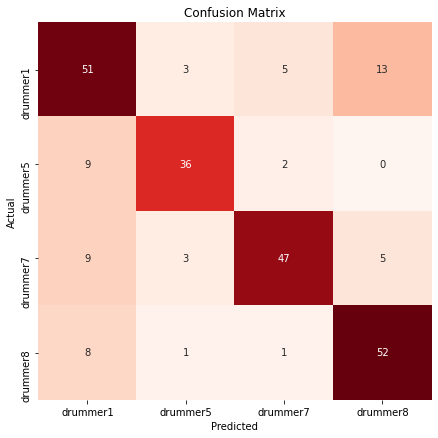

In [46]:
display_classify_results(y_test, y_pred, labels=np.unique(y))

Quick review of stats of the data we're about to use in the model search...

In [47]:
X.describe()
pd.DataFrame(y).describe()
print('Drummers: {}'.format(np.unique(y)))
print('Beat positions: {}'.format(np.unique(X.bar_beat_number)))

,velocity,beat_offset,bar_beat_number
count,1221.000000,1221.000000,1221.000000
mean,68.886978,-6.131859,8.641278
std,34.689707,14.838689,4.426530
min,5.000000,-57.000000,1.000000
25%,40.000000,-16.000000,5.000000
50%,64.000000,-6.000000,9.000000
75%,95.000000,4.000000,13.000000
max,127.000000,59.000000,16.000000


,0
count,1221
unique,4
top,drummer1
freq,360


Drummers: ['drummer1' 'drummer5' 'drummer7' 'drummer8']
Beat positions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


# GridSearch, kNN

Good links!
* https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-cross-validation-and-hyperparameter-tuning/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-learn.org/stable/modules/compose.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

In [84]:
import sklearn
sklearn.__version__  # should be 0.23.2

'0.23.2'

Set data being used in 'Setup & select data...' > 'Song style selection''


In [86]:
print('\n ====>>>> Working with data for style(s): {} '.format(working_data['style'].unique()))

# collect our ColumnTransformers setup earlier ..
grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4, ct_v5]
#grid_cts = [ct_v0, ct_v3, ct_v4]

param_grid_pca_yes = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
                     knn__p=[1, 2, 5], # knn distance functions to test
                     knn__weights=['uniform', 'distance'],
                     pca__n_components=[2,3,4,5, None],
                     pca=[PCA()],
                     prep=grid_cts # list of ColTransformers to search
)

param_grid_pca_no = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
                     knn__p=[1, 2, 5], # knn distance functions to test
                     knn__weights=['uniform', 'distance'],
                     prep=grid_cts # list of ColTransformers to search
)

#stratified for proportional class representation
skf = StratifiedKFold(n_splits=10)

my_pipe = Pipeline(steps=[('prep',None ), ('pca', None), ('knn', KNeighborsClassifier())])
grid_search = GridSearchCV(my_pipe, param_grid=param_grid_pca_yes, cv=skf, verbose=1)
grid_search = GridSearchCV(my_pipe, param_grid=param_grid_pca_no, cv=skf, verbose=1)

print('\n___FITTING ....\n')
grid_search.fit(X_train,y_train)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)



 ====>>>> Working with data for style(s): ['hiphop/groove6'] 

___FITTING ....

Fitting 10 folds for each of 684 candidates, totalling 6840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6840 out of 6840 | elapsed:  3.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prep', None), ('pca', None),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'knn__p': [1, 2, 5],
                         'knn__weights': ['uniform', 'distance'],
                         'prep': [ColumnTransformer(remainder='passthr...
                                                                   ['bar_beat_number'])]),
                                  ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_mm_1',
                                                                   MinMaxScaler(),
                                                                   ['velocity',
                                                                    'beat_offset']),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   ['note',
                                                                    'style']),
                                                                  ('t_one_hot_beat_pos',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2,
                                                                                              3,
                                                                                              4,
                                                                                              5,
                                                                                              6,
                                                                                              7,
                                                                                              8,
                                                                                              9,
                                                                                              10,
                                                                                              11,
                                                                                              12,
                                                                                              13,
                                                                                              14,
                                                                                              15,
                                                                                              16]],
                                                                                 drop='first'),
                                                                   ['bar_beat_number'])])]},
             verbose=1)


___BEST ESTIMATOR



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity']),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  ['beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('pca', None),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])


___BEST SCORE



0.7621817799284663


___BEST PARAMS



{'knn__n_neighbors': 4,
 'knn__p': 2,
 'knn__weights': 'distance',
 'prep': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('t_scaler_mm_1', MinMaxScaler(), ['velocity']),
                                 ('t_scaler_mm_2',
                                  MinMaxScaler(feature_range=(-0.5, 0.5)),
                                  ['beat_offset']),
                                 ('t_one_hot', OneHotEncoder(drop='first'),
                                  ['note', 'style']),
                                 ('t_one_hot_beat_pos',
                                  OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16]],
                                                drop='first'),
                                  ['bar_beat_number'])])}

## Now run best model with the test data ...

From the doc...
* GridSearchCV.predict(X_test) - Call predict on the estimator with the best found parameters.

In [49]:
y_true, y_pred =  y_test, grid_search.predict(X_test)


======== RESULTS FOR STYLE(S): ['hiphop/groove6'] 

Accuracy score 0.7591836734693878

Classification report...
              precision    recall  f1-score   support

    drummer1       0.69      0.69      0.69        72
    drummer5       0.78      0.83      0.80        47
    drummer7       0.89      0.73      0.80        64
    drummer8       0.71      0.81      0.76        62

    accuracy                           0.76       245
   macro avg       0.77      0.77      0.76       245
weighted avg       0.77      0.76      0.76       245


Confusion matrix...


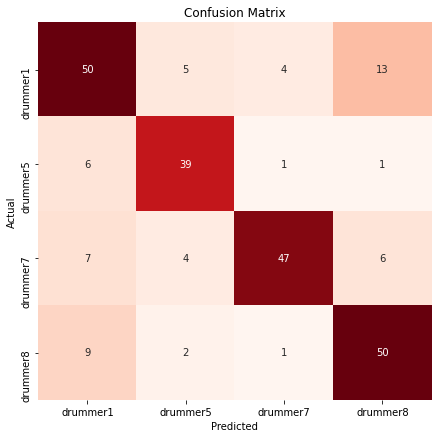

In [54]:

print('\n======== RESULTS FOR STYLE(S): {} '.format(working_data['style'].unique()))
display_classify_results(y_true=y_true, y_pred=y_pred, labels= np.unique(y))


# GridSearch, kNN, manual loop

In [56]:
# note: 'col_trans' is list of ColumnTransformers from earlier.
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#col_trans = [ct_v4]


param_grid_v1 = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
      knn__weights=['uniform', 'distance'],
      knn__p=[1, 2, 5] # knn distance functions to test
)


overall_best_score = 0
overall_best_classifier = None

skf = StratifiedKFold(n_splits=10)

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  my_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier())])
  grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v1, cv=skf, verbose=1)

  print('\n>>>>FITTING ....\n')
  _ = grid_search.fit(X_train,y_train)

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(grid_search.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(grid_search.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(grid_search.best_params_)

  if grid_search.best_score_ > overall_best_score:
    overall_best_score = grid_search.best_score_
    overall_best_classifier = grid_search





_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



___BEST ESTIMATOR, pipe#0



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   33.9s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  ['velocity', 'beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=10, p=1,
                                      weights='distance'))])


___BEST SCORE, pipe#0



0.7479381443298969


___BEST PARAMS, pipe#0



{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'distance'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #1.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits

___BEST ESTIMATOR, pipe#1



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   39.8s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity']),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  ['beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])


___BEST SCORE, pipe#1



0.7621817799284663


___BEST PARAMS, pipe#1



{'knn__n_neighbors': 4, 'knn__p': 2, 'knn__weights': 'distance'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #2.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits

___BEST ESTIMATOR, pipe#2



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   29.6s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity']),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  ['beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])


___BEST SCORE, pipe#2



0.7621817799284663


___BEST PARAMS, pipe#2



{'knn__n_neighbors': 4, 'knn__p': 2, 'knn__weights': 'distance'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #3.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits

___BEST ESTIMATOR, pipe#3



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   22.9s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity', 'beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])


___BEST SCORE, pipe#3



0.7621817799284663


___BEST PARAMS, pipe#3



{'knn__n_neighbors': 4, 'knn__p': 2, 'knn__weights': 'distance'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #4.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits

___BEST ESTIMATOR, pipe#4



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   32.7s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(),
                                                  ['velocity', 'beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=10, p=1,
                                      weights='distance'))])


___BEST SCORE, pipe#4



0.7458447296444352


___BEST PARAMS, pipe#4



{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'distance'}

## Quick sanity check ...

In [57]:

print('overall best_score: {}, classifier score:{}'.format(overall_best_score, overall_best_classifier.best_score_))
print('overall best classifier...')
overall_best_classifier
overall_best_classifier.best_params_
pd.DataFrame.from_dict(overall_best_classifier.cv_results_).head()

overall best_score: 0.7621817799284663, classifier score:0.7621817799284663
overall best classifier...


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_mm_1',
                                                                         MinMaxScaler(),
                                                                         ['velocity']),
                                                                        ('t_scaler_mm_2',
                                                                         MinMaxScaler(feature_range=(-0.5,
                                                                                                     0.5)),
                                                                         ['beat_offset']),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['note',
                                                                          'style']),
                                                                        ('t_one_hot_beat_pos',
                                                                         OneHotEncoder(categories=[[1,
                                                                                                    2,
                                                                                                    3,
                                                                                                    4,
                                                                                                    5,
                                                                                                    6,
                                                                                                    7,
                                                                                                    8,
                                                                                                    9,
                                                                                                    10,
                                                                                                    11,
                                                                                                    12,
                                                                                                    13,
                                                                                                    14,
                                                                                                    15,
                                                                                                    16]],
                                                                                       drop='first'),
                                                                         ['bar_beat_number'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'knn__p': [1, 2, 5],
                         'knn__weights': ['uniform', 'distance']},
             verbose=1)

{'knn__n_neighbors': 4, 'knn__p': 2, 'knn__weights': 'distance'}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016724,0.001460,0.012224,0.000718,1,1,uniform,"{'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}",0.785714,0.785714,0.765306,0.785714,0.744898,0.744898,0.762887,0.659794,0.701031,0.690722,0.742668,0.042179,40
1,0.015600,0.000321,0.010229,0.001480,1,1,distance,"{'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'distance'}",0.785714,0.785714,0.765306,0.785714,0.744898,0.744898,0.762887,0.659794,0.701031,0.690722,0.742668,0.042179,40
2,0.015972,0.001030,0.012205,0.000947,1,2,uniform,"{'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'uniform'}",0.755102,0.775510,0.775510,0.765306,0.755102,0.744898,0.773196,0.680412,0.731959,0.690722,0.744772,0.032497,30
3,0.015592,0.000303,0.009704,0.000280,1,2,distance,"{'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'distance'}",0.755102,0.775510,0.775510,0.765306,0.755102,0.744898,0.773196,0.680412,0.731959,0.690722,0.744772,0.032497,30
4,0.016445,0.000320,0.023158,0.001179,1,5,uniform,"{'knn__n_neighbors': 1, 'knn__p': 5, 'knn__weights': 'uniform'}",0.765306,0.785714,0.755102,0.755102,0.775510,0.744898,0.762887,0.680412,0.731959,0.670103,0.742699,0.036638,37


## Chart results 

In [58]:
grid_results = pd.DataFrame(overall_best_classifier.cv_results_['params'])
grid_results['test_score'] = overall_best_classifier.cv_results_['mean_test_score']
grid_results['metric'] = grid_results['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
grid_results.head()

,knn__n_neighbors,knn__p,knn__weights,test_score,metric
0,1,1,uniform,0.742668,Manhattan
1,1,1,distance,0.742668,Manhattan
2,1,2,uniform,0.744772,Euclidean
3,1,2,distance,0.744772,Euclidean
4,1,5,uniform,0.742699,Minkowski


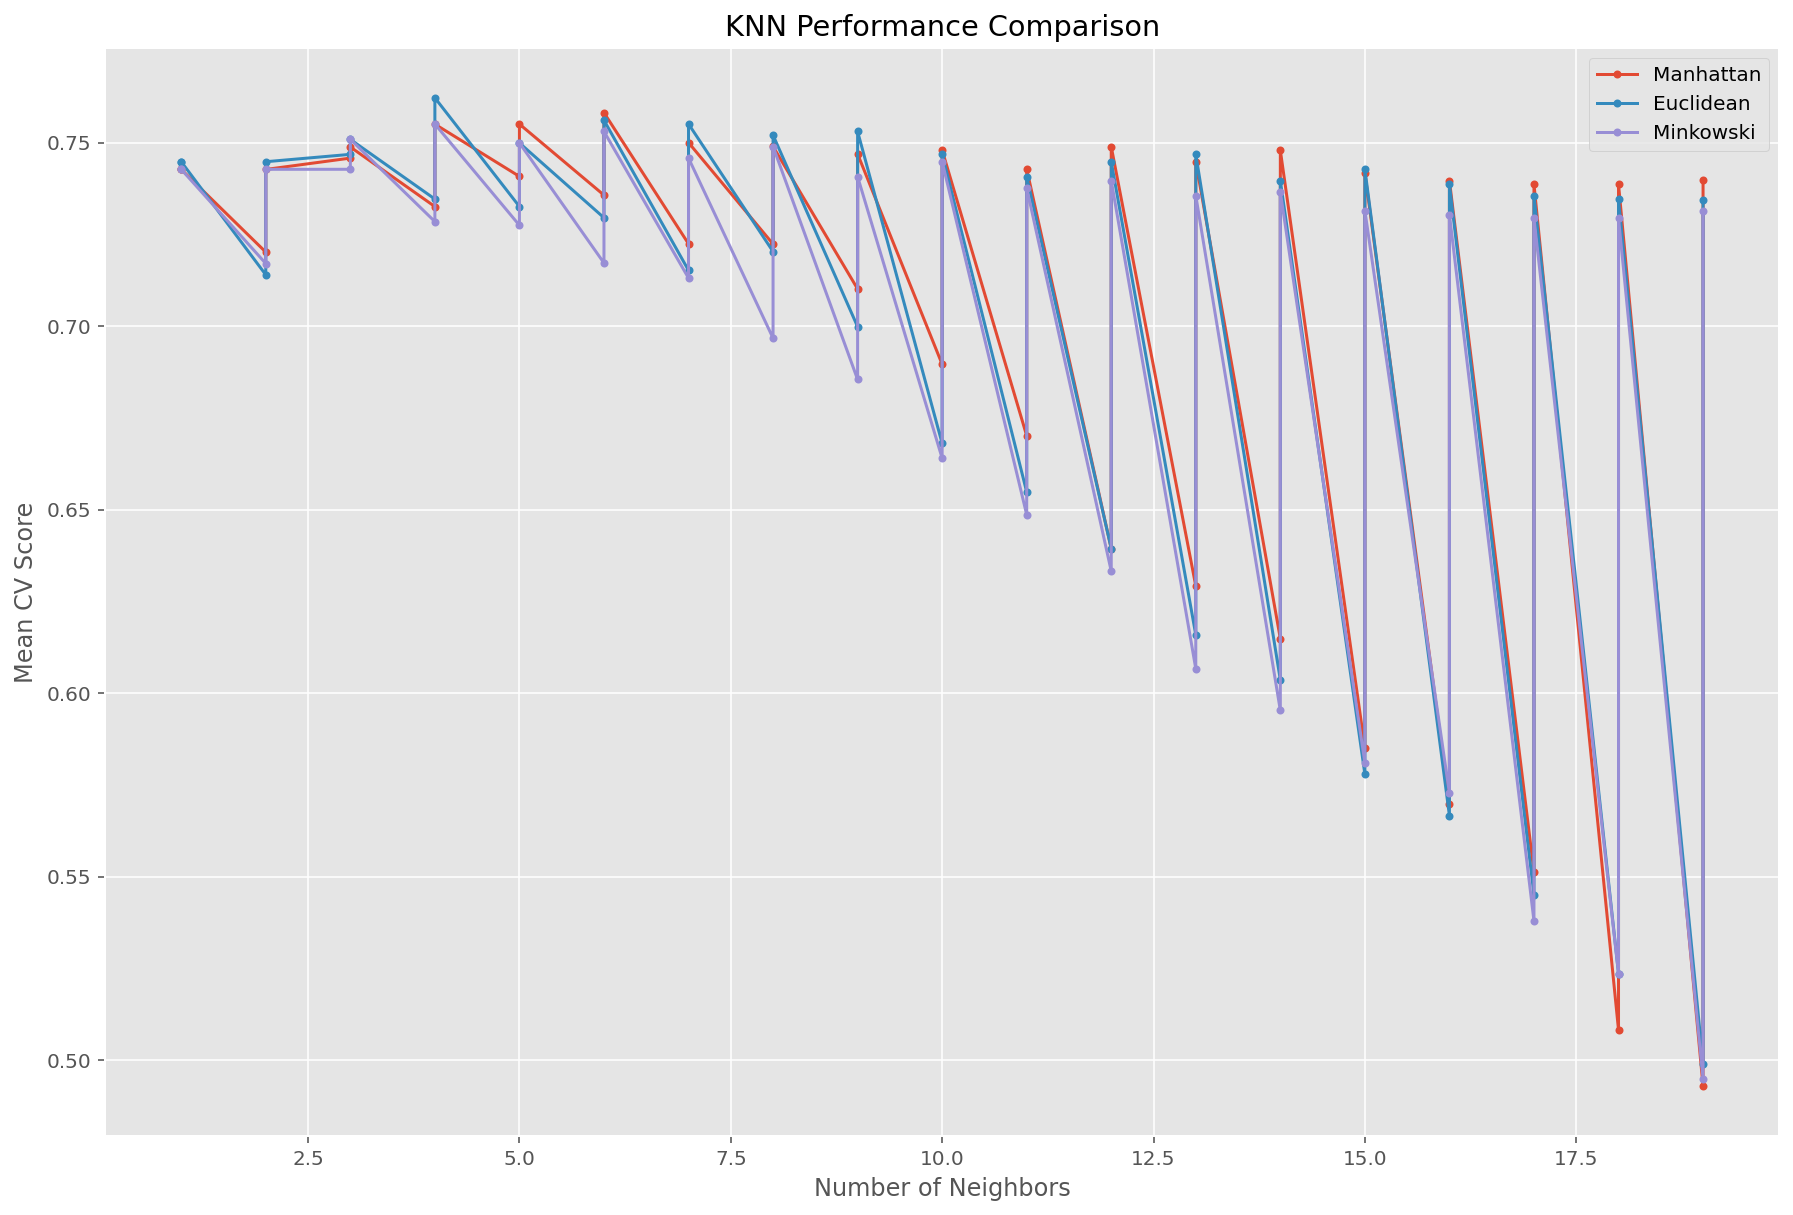

In [59]:

import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = grid_results[grid_results['metric'] == i]
    _ = plt.plot(temp['knn__n_neighbors'], temp['test_score'], marker = '.', label = i)
    
_ = plt.legend()
_ = plt.xlabel('Number of Neighbors')
_ = plt.ylabel("Mean CV Score")
_ = plt.title("KNN Performance Comparison")
plt.show()

## Run on test data

In [60]:
y_pred = overall_best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.69      0.69      0.69        72
    drummer5       0.78      0.83      0.80        47
    drummer7       0.89      0.73      0.80        64
    drummer8       0.71      0.81      0.76        62

    accuracy                           0.76       245
   macro avg       0.77      0.77      0.76       245
weighted avg       0.77      0.76      0.76       245



# kNN ensemble TODO, TRY THIS!!
* https://scikit-learn.org/stable/modules/ensemble.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [ ]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

# Decision Tree

- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
- https://scikit-learn.org/stable/modules/tree.html

In [61]:
X_train.describe()
X_train_prepped = ct_v4.fit_transform(X_train)

tmp_df1 = pd.DataFrame(X_train_prepped)
tmp_df1.head()


,velocity,beat_offset,bar_beat_number
count,976.000000,976.000000,976.000000
mean,69.394467,-6.241803,8.594262
std,34.876443,14.696552,4.432899
min,5.000000,-55.000000,1.000000
25%,40.000000,-16.000000,5.000000
50%,64.000000,-6.000000,9.000000
75%,96.000000,4.000000,12.250000
max,127.000000,59.000000,16.000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-1.589120,-0.460085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.652550,-0.596241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.044061,0.901476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.418994,0.493008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.154753,-1.072787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [62]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#tree_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
tree_clf = DecisionTreeClassifier(max_depth=4)


tree_clf.fit(X_train_prepped, y_train)
#tree.plot_tree(tree_clf) 


DecisionTreeClassifier(max_depth=4)

In [63]:
from sklearn import metrics
X_test_prepped = ct_v4.fit_transform(X_test)
y_pred = tree_clf.predict(X_test_prepped)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5755102040816327


## GridSearchCV, DT

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=999)
dt_depth = list(np.arange(1, 20))

# can try modelling with scaling & dummies using previous setup ColTransformers...
#dt_prep_pipe = Pipeline(steps=[('prep',ct_v4), ('tree_clf', tree_clf)])

# apparently no scaling or dummies needed for DT
# new one to just encode 'note', leave everything else untouched
dt_enc_pipe = Pipeline(steps=[ ('enc', ct_ord_enc ), ('tree_clf', tree_clf)])

# setup param grid...
dt_params = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

# choose from dt_enc_pipe or dt_prep_pipe
my_clf = dt_enc_pipe

skf = StratifiedKFold(n_splits=10)

gscv_dt = GridSearchCV(estimator=my_clf, 
                     param_grid=dt_params, 
                     cv=skf,
                     verbose=1, 
                     scoring='accuracy')

gscv_dt.fit(X_train, y_train);

Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:    6.6s finished


In [ ]:
gscv_dt.best_params_

{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 7,
 'tree_clf__min_samples_split': 3}

In [ ]:
gscv_dt.best_score_

0.5299786153434911

In [ ]:
results_DT = pd.DataFrame(gscv_dt.cv_results_['params'])
results_DT['test_score'] = gscv_dt.cv_results_['mean_test_score']
results_DT.columns

Index(['tree_clf__criterion', 'tree_clf__max_depth',
       'tree_clf__min_samples_split', 'test_score'],
      dtype='object')

Text(0.5, 0, 'Max Depth')

Text(0, 0.5, 'Mean CV Score')

Text(0.5, 1.0, 'DT Performance Comparison')

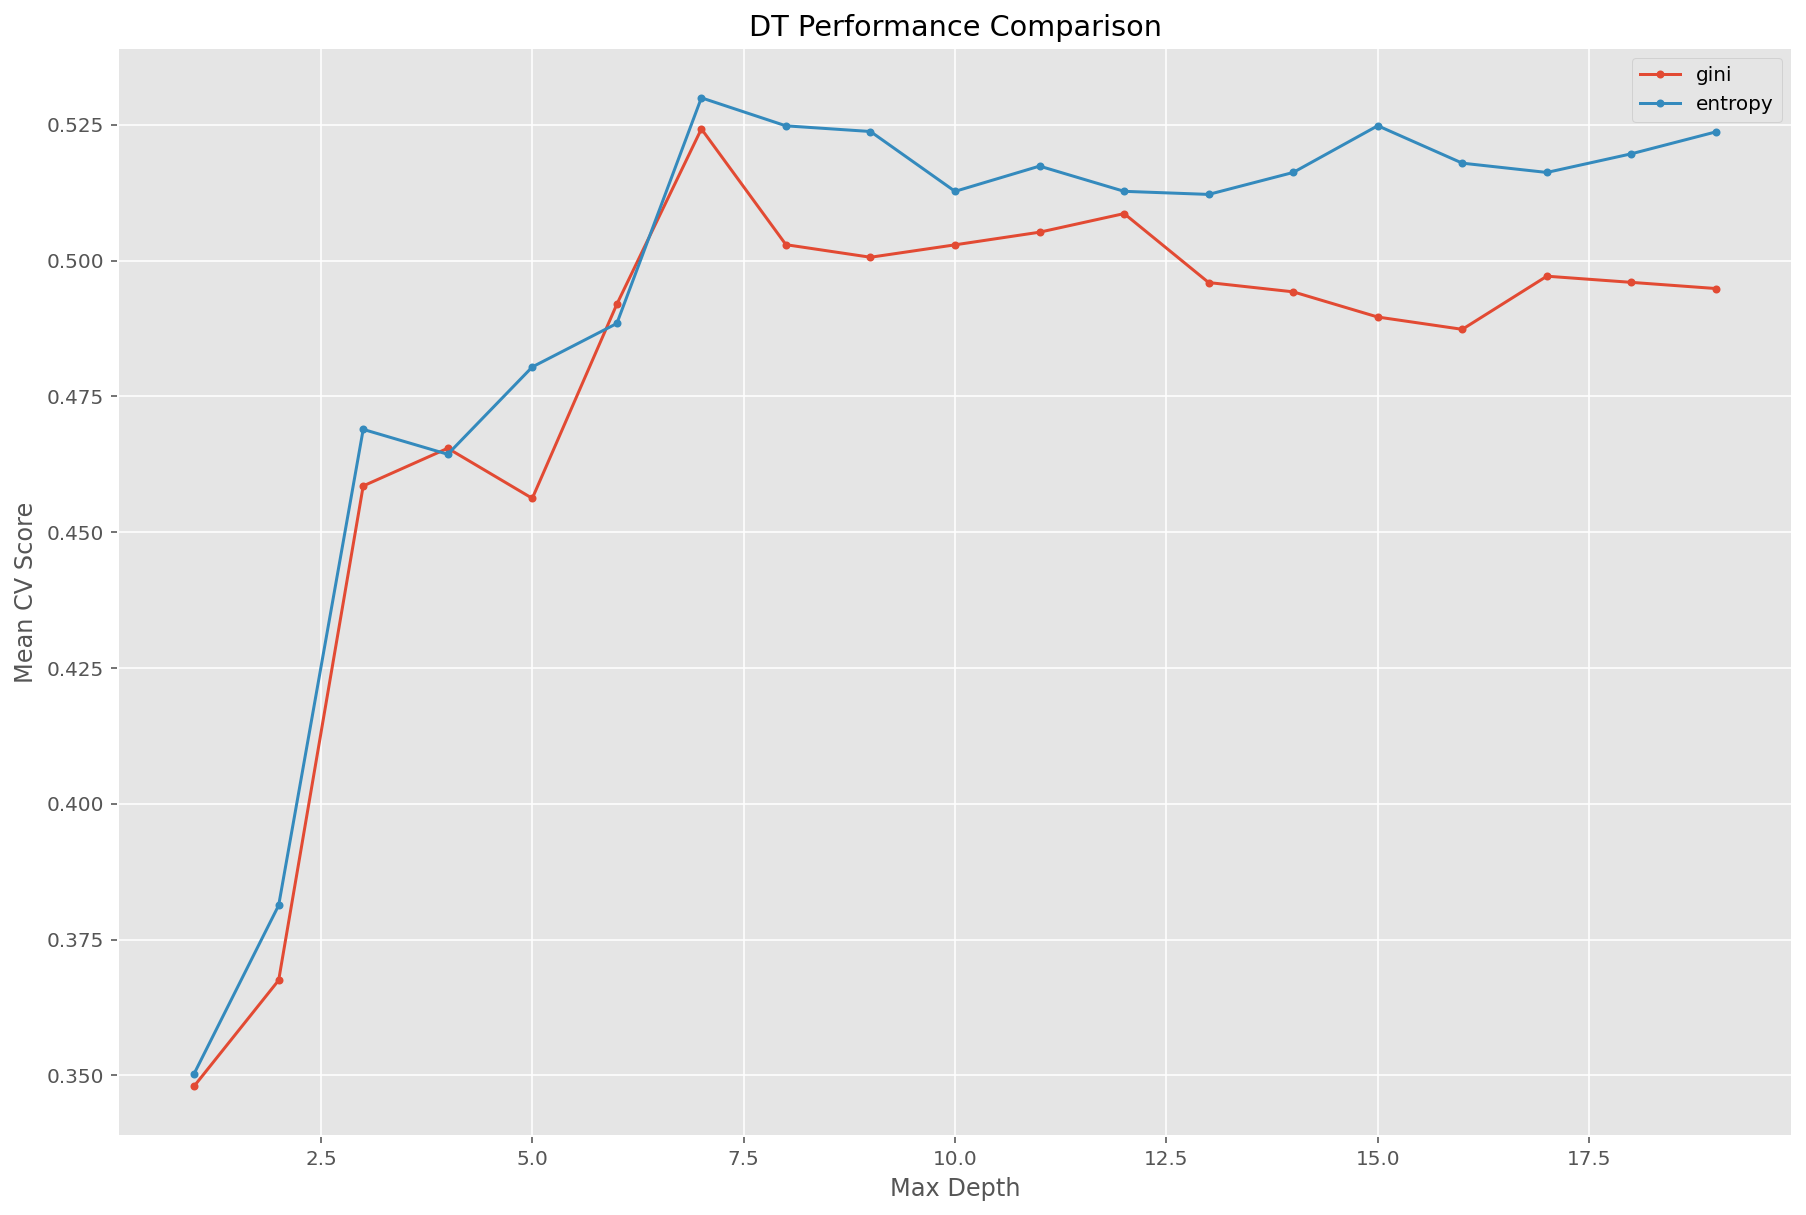

In [ ]:
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['tree_clf__criterion'] == i]
    temp_average = temp.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## GridSearchCV, DT, manual loop

In [ ]:
# list of ColumnTransformers setup previously
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4, ct_ord_enc ]
#col_trans = [ct_v4, ct_ord_enc ]

dt_depth = list(np.arange(1, 20))

dt_params_grid = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

overall_best_score = 0
overall_best_classifier2 = None

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  dt_pipe = Pipeline(steps=[('prep',ct), ('tree_clf', DecisionTreeClassifier(random_state=999))])
  gscv_dt = GridSearchCV(estimator=dt_pipe, 
                     param_grid=dt_params_grid, 
                     cv=10,
                     verbose=1, 
                     scoring='accuracy')

  print('\n>>>>FITTING ....\n')
  _ = gscv_dt.fit(X_train, y_train);

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(gscv_dt.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(gscv_dt.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(gscv_dt.best_params_)

  if gscv_dt.best_score_ > overall_best_score:
    overall_best_score = gscv_dt.best_score_
    overall_best_classifier2 = gscv_dt


_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



___BEST ESTIMATOR, pipe#0



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   12.0s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=17,
                                        random_state=999))])


___BEST SCORE, pipe#0



0.5299919807538093


___BEST PARAMS, pipe#0



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 17,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #1.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#1



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   17.4s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=999))])


___BEST SCORE, pipe#1



0.5404570970328789


___BEST PARAMS, pipe#1



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 10,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #2.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#2



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   15.6s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=17,
                                        random_state=999))])


___BEST SCORE, pipe#2



0.5276931301790965


___BEST PARAMS, pipe#2



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 17,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #3.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#3



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   11.6s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=17,
                                        random_state=999))])


___BEST SCORE, pipe#3



0.5276931301790965


___BEST PARAMS, pipe#3



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 17,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #4.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#4



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   13.4s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=999))])


___BEST SCORE, pipe#4



0.5393076717455225


___BEST PARAMS, pipe#4



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 10,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #5.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#5



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:    6.7s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_label_enc',
                                                  OrdinalEncoder(), [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                        min_samples_split=3,
                                        random_state=999))])


___BEST SCORE, pipe#5



0.5299786153434911


___BEST PARAMS, pipe#5



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 7,
 'tree_clf__min_samples_split': 3}

Overall ...

In [ ]:
print('\n Overall .. BEST SCORE')
display(overall_best_classifier2.best_score_)

print('\n Overall .. BEST PARAMS')
display(overall_best_classifier2.best_params_)


 Overall .. BEST SCORE


0.5404570970328789


 Overall .. BEST PARAMS


{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 10,
 'tree_clf__min_samples_split': 2}

## Chart results

In [ ]:
dt_results = pd.DataFrame(overall_best_classifier2.cv_results_['params'])
dt_results['test_score'] = overall_best_classifier2.cv_results_['mean_test_score']
dt_results.columns

Index(['tree_clf__criterion', 'tree_clf__max_depth',
       'tree_clf__min_samples_split', 'test_score'],
      dtype='object')

Text(0.5, 0, 'Max Depth')

Text(0, 0.5, 'Mean CV Score')

Text(0.5, 1.0, 'DT Performance Comparison')

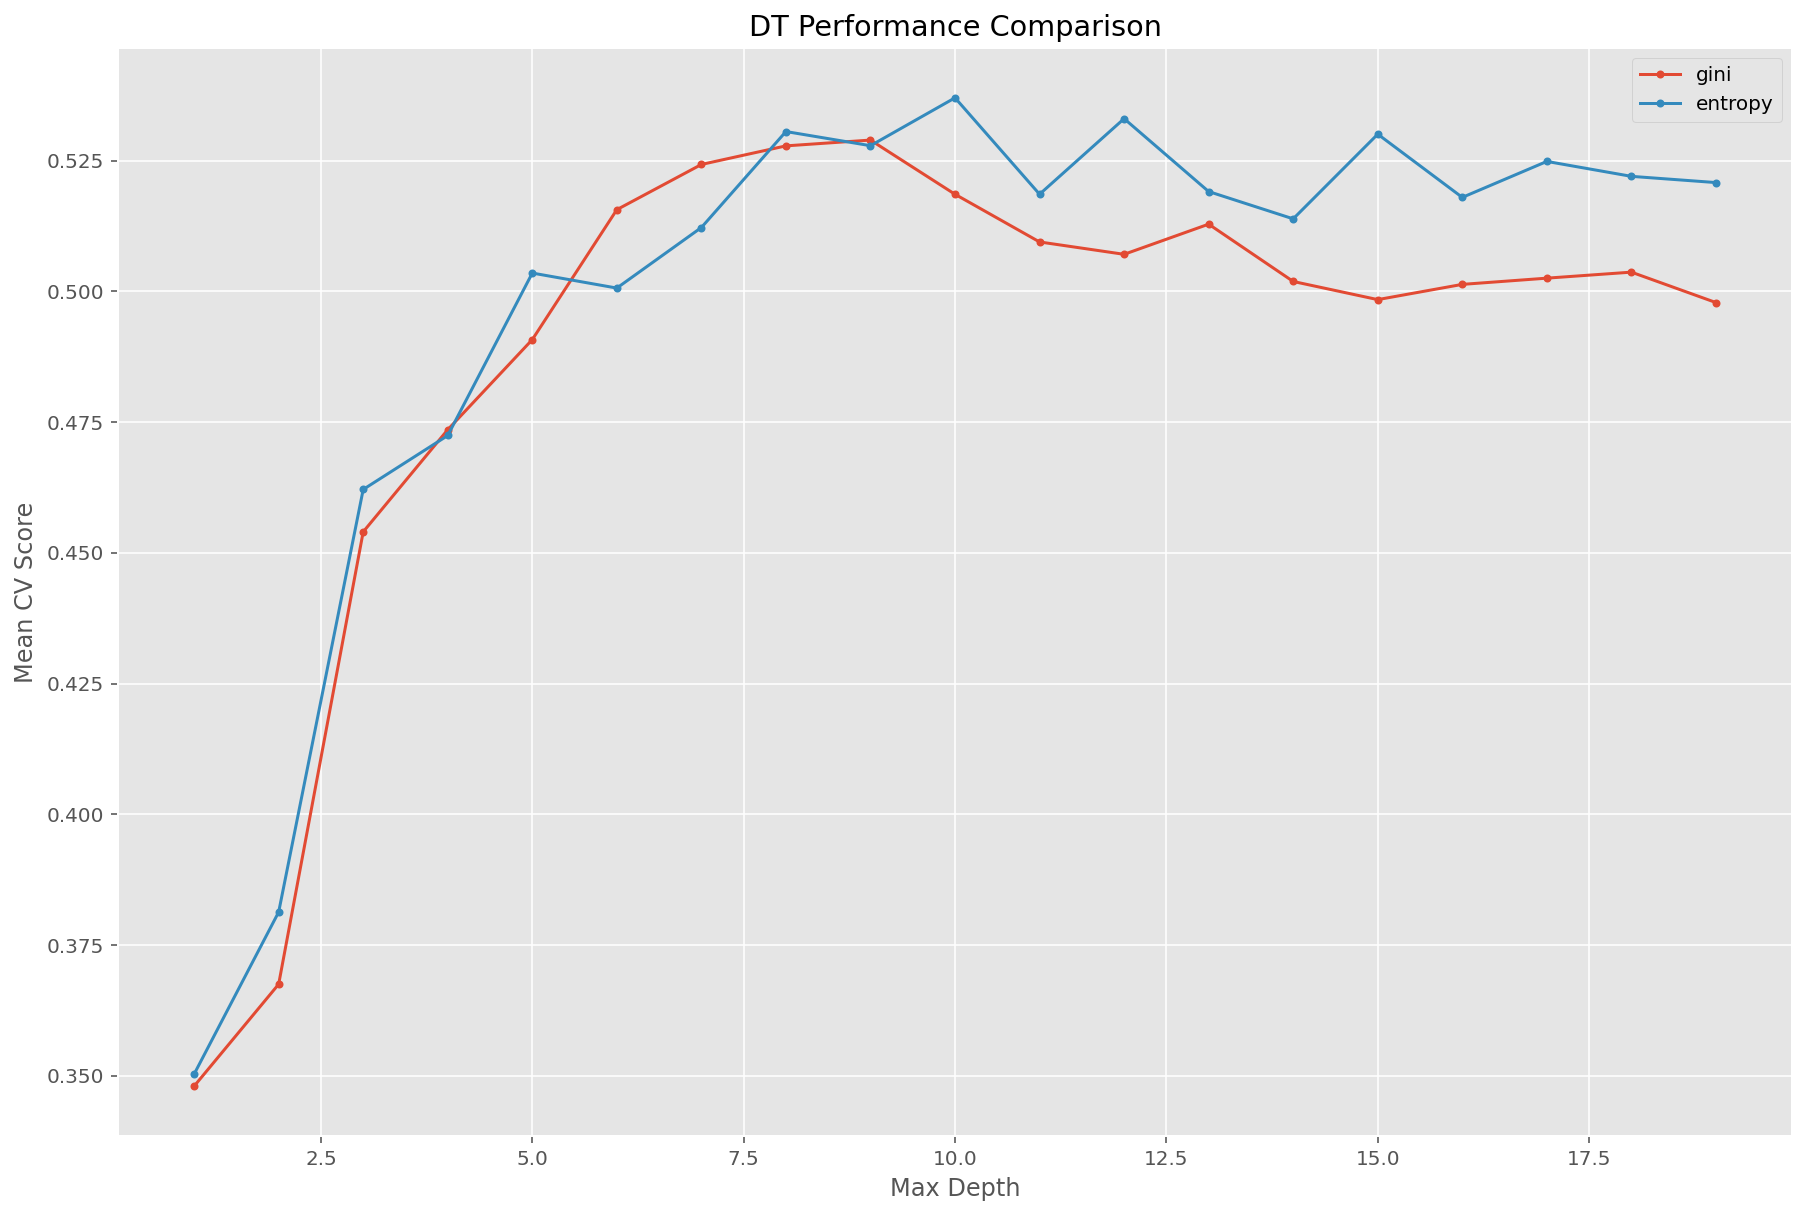

In [ ]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ['gini', 'entropy']:
    tmp_crit = dt_results[dt_results['tree_clf__criterion'] == i]
    tmp_avg = tmp_crit.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(tmp_avg, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## Run on test data

In [ ]:
y_pred = overall_best_classifier2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.50      0.48      0.49        52
    drummer5       0.53      0.48      0.50        60
    drummer7       0.65      0.48      0.55        50
    drummer8       0.47      0.64      0.55        56

    accuracy                           0.52       218
   macro avg       0.54      0.52      0.52       218
weighted avg       0.53      0.52      0.52       218



# GradientBoostingClassifier

See...
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
* https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting


.. and..
* https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
* https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/


In [65]:
sklearn.__version__  # should be 0.23.2

#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
  #max_depth=1, random_state=0).fit(X_train, y_train)
gbc_clf = GradientBoostingClassifier()


'0.23.2'

In [ ]:
# note: 'grid_cts' is list of ColumnTransformers from earlier.
# list of ColumnTransformers setup earlier ..
#grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4, ct_ord_enc ]
#grid_cts = [ct_ord_enc ]
grid_cts = [ct_v0, ct_v3, ct_v4]


param_grid_v0 = dict(
    gbc_clf__n_estimators=[10, 50, 100, 250, 500, 1000], 
    gbc_clf__learning_rate=[0.1, 0.3, 0.5], 
    gbc_clf__max_depth=[3, 5, 7], 
    gbc_clf__random_state=[0],
    gbc_clf__max_features=['auto'], 
    prep=grid_cts # list of ColTransformers to search
)

# search all pipes in grid_cts
my_pipe = Pipeline(steps=[('prep',None), ('gbc_clf', gbc_clf)])
grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v0, cv=10, verbose=1)

print('\n>>>>FITTING ....\n')
grid_search.fit(X_train,y_train)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)





>>>>FITTING ....

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [66]:
y_true, y_pred = y_test, grid_search.predict(X_test)
display_classify_results(y_true, y_pred, labels)

NameError: ignored

Previously, in this other notebook...
*  https://colab.research.google.com/drive/1wlXUtA3s_9FU5_4whCvO9MdlYvXz1wLJ?usp=sharing

.. was able to get the score below...


```

y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    drummer1       0.69      0.70      0.70        84
    drummer5       0.86      0.84      0.85        45
    drummer7       0.80      0.76      0.78        59
    drummer8       0.67      0.70      0.68        57

    accuracy                           0.74       245
   macro avg       0.76      0.75      0.75       245
weighted avg       0.75      0.74      0.74       245
```



# SVM with RBF

* https://scikit-learn.org/stable/modules/svm.html#classification
* https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [ ]:
from sklearn.svm import SVC

In [ ]:
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.
#C_range = np.logspace(-2, 10, 13)
C_range = np.logspace(-2, 10, 3)
#gamma_range = np.logspace(-9, 3, 13)
gamma_range = np.logspace(-9, 3, 3)


In [ ]:
print('C range: {}'.format(C_range))
print('Gamma range: {}'.format(gamma_range))

# list of ColumnTransformers setup previously
#col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
col_trans = [ct_v0]



svm_params_grid = {'svc_clf__gamma': gamma_range,
                  'svc_clf__C': C_range}

overall_best_score = 0
overall_best_classifier3 = None

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  svm_pipe = Pipeline(steps=[('prep',ct), ('svc_clf', SVC(kernel='rbf'))])
  gscv_svm = GridSearchCV(estimator=svm_pipe, 
                     param_grid=svm_params_grid, 
                     cv=5,
                     verbose=1, 
                     scoring='accuracy')

  print('\n>>>>FITTING ....\n')
  _ = gscv_svm.fit(X_train, y_train);

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(gscv_svm.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(gscv_svm.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(gscv_svm.best_params_)

  if gscv_svm.best_score_ > overall_best_score:
    overall_best_score = gscv_svm.best_score_
    overall_best_classifier3 = gscv_svm

C range: [1.e-02 1.e+04 1.e+10]
Gamma range: [1.e-09 1.e-03 1.e+03]

_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  9.6min finished



___BEST ESTIMATOR, pipe#0



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('svc_clf', SVC(C=10000000000.0, gamma=0.001))])


___BEST SCORE, pipe#0



0.4516576971629792


___BEST PARAMS, pipe#0



{'svc_clf__C': 10000000000.0, 'svc_clf__gamma': 0.001}

.... waiting on that last cell to complete!!!!!

# VotingClassifier

Review classifiers so far...

In [ ]:
overall_best_classifier.best_estimator_
overall_best_classifier2.best_estimator_
overall_best_classifier3.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'))])

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=999))])

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('svc_clf', SVC(C=10000000000.0, gamma=0.001))])

Create a voting ensemble aggregate of all prior best classifiers...

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

eclf = VotingClassifier(estimators=[('knn', overall_best_classifier.best_estimator_), 
                                    ('dt', overall_best_classifier2.best_estimator_), 
                                    ('svm', overall_best_classifier3.best_estimator_), 
                                    ],voting='hard')

In [ ]:
for clf, label in zip([overall_best_classifier.best_estimator_, 
                       overall_best_classifier2.best_estimator_, 
                       overall_best_classifier3.best_estimator_, 
                       eclf],
                      ['KNN', 'DT', 'SVM', 'Ensemble']):
  scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.61 (+/- 0.02) [KNN]
Accuracy: 0.50 (+/- 0.03) [DT]
Accuracy: 0.47 (+/- 0.00) [SVM]
Accuracy: 0.59 (+/- 0.01) [Ensemble]
